# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$
* `WoldModelVariationalFixedBeta`: VI with parameters $\alpha$ only ($\beta$ are fixed hyper-parameters)

---

Load extensions for debugging

In [107]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Import the libraries of interest for this notebook

In [108]:
import itertools
import torch
import numpy as np

from tsvar.simulate import GrangerBuscaSimulator
from tsvar.models import WoldModelVariational, WoldModelVariationalFixedBeta

---

## Generate small toy example dataset

Define model parameters

In [120]:
dim = 4

baseline = np.array([0.15, 0.15, 0.2, .3])

# adjacency[i,j] = magnitude of influence from i to j
adjacency = np.array([
    [0.3, 0.8, 0.1, 0],
    [0.2, 0.3, 0.1, 0],
    [0, 0.1, 0.0, .1],
    [0, 0.1, 0.0, .1]
])

beta = np.array([1.3, 1.8, 1.1, 1.2])

#beta = 1

end_time = 5e4

for i, j in itertools.product(range(dim), repeat=2):
    print(f"w({j:d} -> {i:d}) = {adjacency[j,i]:.2f}")

w(0 -> 0) = 0.30
w(1 -> 0) = 0.20
w(2 -> 0) = 0.00
w(3 -> 0) = 0.00
w(0 -> 1) = 0.80
w(1 -> 1) = 0.30
w(2 -> 1) = 0.10
w(3 -> 1) = 0.10
w(0 -> 2) = 0.10
w(1 -> 2) = 0.10
w(2 -> 2) = 0.00
w(3 -> 2) = 0.00
w(0 -> 3) = 0.00
w(1 -> 3) = 0.00
w(2 -> 3) = 0.10
w(3 -> 3) = 0.10


Simulate a dataset

In [121]:
wold_sim = GrangerBuscaSimulator(mu_rates=baseline, Alpha_ba=adjacency, Beta_b=beta * np.ones((dim,)))
events = wold_sim.simulate(end_time, seed=42)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]


print('Number of events per dimension:', list(map(len, events)))
print('Total number of events:', sum(map(len, events)))
print()
print(events[0])
print()
print(events[1])
print()
print(events[2])

Number of events per dimension: [15191, 27633, 13164, 18191]
Total number of events: 74179

tensor([9.4040e+00, 1.0396e+01, 1.2116e+01,  ..., 4.9989e+04, 4.9995e+04,
        4.9998e+04])

tensor([8.5437e-01, 2.6646e+00, 8.4426e+00,  ..., 4.9993e+04, 4.9995e+04,
        4.9997e+04])

tensor([1.0307e+01, 1.1297e+01, 1.4340e+01,  ..., 4.9992e+04, 4.9995e+04,
        4.9995e+04])


In [122]:
beta * np.ones((dim,))


array([1.3, 1.8, 1.1, 1.2])

---

## Test variational inference algorithm

Create model object and set the data.

In [123]:
model = WoldModelVariational(verbose=True)
model.observe(events)

Define the parameters of the prior.

In [124]:
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

Fit the model.

In [125]:
model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, max_iter=1000, tol=1e-5)

-------------------------------------------------- 0
Alpha posterior mean:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Z[0] posterior probabilities
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 ...
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
-------------------------------------------------- 1
Alpha posterior mean:
[[0.06 0.11 0.05 0.07]
 [0.14 0.25 0.11 0.15]
 [0.1  0.18 0.09 0.12]
 [0.14 0.25 0.12 0.17]
 [0.12 0.21 0.1  0.14]]
Z posterior probabilities
[[0.19978244 0.20010465 0.19998244 0.20009416 0.2000363 ]
 [0.19978244 0.20010465 0.19998244 0.20009416 0.2000363 ]
 [0.24972257 0.25012533 0.         0.25011221 0.25003989]
 ...
 [0.49961023 0.         0.         0.50038977 0.        ]
 [0.4997556  0.         0.         0.         0.5002444 ]
 [0.33304898 0.         0.33338239 0.33356863 0.        ]]
-------------------------------------------------- 2
Alpha posterior mean:
[[0.11 0.19 0.09 0.13]
 [0.23 

Z posterior probabilities
[[0.60043983 0.11539821 0.11464817 0.07843495 0.09107883]
 [0.60043983 0.11539821 0.11464817 0.07843495 0.09107883]
 [0.60043983 0.11539821 0.11464817 0.07843495 0.09107883]
 ...
 [0.60137886 0.11557868 0.11482747 0.07855761 0.08965737]
 [0.60043983 0.11539821 0.11464817 0.07843495 0.09107883]
 [0.60043983 0.11539821 0.11464817 0.07843495 0.09107883]]
-------------------------------------------------- 17
Alpha posterior mean:
[[0.18 0.33 0.17 0.23]
 [0.41 0.84 0.26 0.3 ]
 [0.23 0.44 0.2  0.24]
 [0.28 0.57 0.24 0.41]
 [0.24 0.44 0.21 0.33]]
Z posterior probabilities
[[0.60461609 0.1146627  0.11322539 0.07752307 0.08997276]
 [0.60461609 0.1146627  0.11322539 0.07752307 0.08997276]
 [0.60461609 0.1146627  0.11322539 0.07752307 0.08997276]
 ...
 [0.60511692 0.11475768 0.11331918 0.07758729 0.08921894]
 [0.60461609 0.1146627  0.11322539 0.07752307 0.08997276]
 [0.60461609 0.1146627  0.11322539 0.07752307 0.08997276]]
------------------------------------------------

Z posterior probabilities
[[0.63847623 0.10913519 0.10177819 0.06978296 0.08082744]
 [0.63847623 0.10913519 0.10177819 0.06978296 0.08082744]
 [0.63847623 0.10913519 0.10177819 0.06978296 0.08082744]
 ...
 [0.63847623 0.10913519 0.10177819 0.06978296 0.08082744]
 [0.63847623 0.10913519 0.10177819 0.06978296 0.08082744]
 [0.63847623 0.10913519 0.10177819 0.06978296 0.08082744]]
-------------------------------------------------- 32
Alpha posterior mean:
[[0.19 0.35 0.18 0.25]
 [0.45 0.93 0.26 0.3 ]
 [0.23 0.47 0.21 0.24]
 [0.28 0.59 0.24 0.43]
 [0.24 0.44 0.21 0.34]]
Z posterior probabilities
[[0.63991846 0.10891663 0.10128213 0.06942811 0.08045467]
 [0.63991846 0.10891663 0.10128213 0.06942811 0.08045467]
 [0.63991846 0.10891663 0.10128213 0.06942811 0.08045467]
 ...
 [0.63991846 0.10891663 0.10128213 0.06942811 0.08045467]
 [0.63991846 0.10891663 0.10128213 0.06942811 0.08045467]
 [0.63991846 0.10891663 0.10128213 0.06942811 0.08045467]]
------------------------------------------------

Z posterior probabilities
[[0.65433386 0.10682454 0.09642078 0.06563842 0.0767824 ]
 [0.65433386 0.10682454 0.09642078 0.06563842 0.0767824 ]
 [0.65433386 0.10682454 0.09642078 0.06563842 0.0767824 ]
 ...
 [0.65433386 0.10682454 0.09642078 0.06563842 0.0767824 ]
 [0.65433386 0.10682454 0.09642078 0.06563842 0.0767824 ]
 [0.65433386 0.10682454 0.09642078 0.06563842 0.0767824 ]]
-------------------------------------------------- 47
Alpha posterior mean:
[[0.2  0.36 0.18 0.25]
 [0.47 0.98 0.27 0.29]
 [0.23 0.49 0.22 0.23]
 [0.28 0.6  0.23 0.43]
 [0.24 0.44 0.21 0.34]]
Z posterior probabilities
[[0.65505174 0.10676249 0.09616168 0.06542947 0.07659462]
 [0.65505174 0.10676249 0.09616168 0.06542947 0.07659462]
 [0.65505174 0.10676249 0.09616168 0.06542947 0.07659462]
 ...
 [0.65505174 0.10676249 0.09616168 0.06542947 0.07659462]
 [0.65505174 0.10676249 0.09616168 0.06542947 0.07659462]
 [0.65505174 0.10676249 0.09616168 0.06542947 0.07659462]]
------------------------------------------------

Z posterior probabilities
[[0.66293515 0.10649024 0.09306819 0.06307678 0.07442965]
 [0.66293515 0.10649024 0.09306819 0.06307678 0.07442965]
 [0.66293515 0.10649024 0.09306819 0.06307678 0.07442965]
 ...
 [0.66293515 0.10649024 0.09306819 0.06307678 0.07442965]
 [0.66293515 0.10649024 0.09306819 0.06307678 0.07442965]
 [0.66293515 0.10649024 0.09306819 0.06307678 0.07442965]]
-------------------------------------------------- 62
Alpha posterior mean:
[[0.2  0.36 0.18 0.26]
 [0.48 1.01 0.26 0.29]
 [0.23 0.5  0.22 0.22]
 [0.27 0.6  0.23 0.44]
 [0.24 0.43 0.2  0.34]]
Z posterior probabilities
[[0.66338507 0.10650294 0.09288215 0.06293627 0.07429357]
 [0.66338507 0.10650294 0.09288215 0.06293627 0.07429357]
 [0.66338507 0.10650294 0.09288215 0.06293627 0.07429357]
 ...
 [0.66338507 0.10650294 0.09288215 0.06293627 0.07429357]
 [0.66338507 0.10650294 0.09288215 0.06293627 0.07429357]
 [0.66338507 0.10650294 0.09288215 0.06293627 0.07429357]]
------------------------------------------------

Z posterior probabilities
[[0.66854777 0.10694416 0.09079403 0.0611525  0.07256153]
 [0.66854777 0.10694416 0.09079403 0.0611525  0.07256153]
 [0.66854777 0.10694416 0.09079403 0.0611525  0.07256153]
 ...
 [0.66854777 0.10694416 0.09079403 0.0611525  0.07256153]
 [0.66854777 0.10694416 0.09079403 0.0611525  0.07256153]
 [0.66854777 0.10694416 0.09079403 0.0611525  0.07256153]]
-------------------------------------------------- 77
Alpha posterior mean:
[[0.2  0.37 0.18 0.26]
 [0.5  1.03 0.26 0.28]
 [0.23 0.51 0.22 0.22]
 [0.26 0.6  0.22 0.44]
 [0.24 0.42 0.2  0.34]]
Z posterior probabilities
[[0.66884855 0.10699066 0.09067701 0.06103386 0.07244992]
 [0.66884855 0.10699066 0.09067701 0.06103386 0.07244992]
 [0.66884855 0.10699066 0.09067701 0.06103386 0.07244992]
 ...
 [0.66884855 0.10699066 0.09067701 0.06103386 0.07244992]
 [0.66884855 0.10699066 0.09067701 0.06103386 0.07244992]
 [0.66884855 0.10699066 0.09067701 0.06103386 0.07244992]]
------------------------------------------------

Z posterior probabilities
[[0.67247713 0.10778745 0.0892629  0.05944121 0.07103131]
 [0.67247713 0.10778745 0.0892629  0.05944121 0.07103131]
 [0.67247713 0.10778745 0.0892629  0.05944121 0.07103131]
 ...
 [0.67247713 0.10778745 0.0892629  0.05944121 0.07103131]
 [0.67247713 0.10778745 0.0892629  0.05944121 0.07103131]
 [0.67247713 0.10778745 0.0892629  0.05944121 0.07103131]]
-------------------------------------------------- 92
Alpha posterior mean:
[[0.2  0.37 0.18 0.26]
 [0.51 1.04 0.25 0.28]
 [0.23 0.52 0.22 0.21]
 [0.25 0.6  0.21 0.43]
 [0.23 0.4  0.19 0.33]]
Z posterior probabilities
[[0.67270193 0.10785629 0.08917258 0.05933093 0.07093827]
 [0.67270193 0.10785629 0.08917258 0.05933093 0.07093827]
 [0.67270193 0.10785629 0.08917258 0.05933093 0.07093827]
 ...
 [0.67270193 0.10785629 0.08917258 0.05933093 0.07093827]
 [0.67270193 0.10785629 0.08917258 0.05933093 0.07093827]
 [0.67270193 0.10785629 0.08917258 0.05933093 0.07093827]]
------------------------------------------------

Z posterior probabilities
[[0.67547047 0.1090253  0.08798866 0.05781236 0.0697032 ]
 [0.67547047 0.1090253  0.08798866 0.05781236 0.0697032 ]
 [0.67547047 0.1090253  0.08798866 0.05781236 0.0697032 ]
 ...
 [0.67547047 0.1090253  0.08798866 0.05781236 0.0697032 ]
 [0.67547047 0.1090253  0.08798866 0.05781236 0.0697032 ]
 [0.67547047 0.1090253  0.08798866 0.05781236 0.0697032 ]]
-------------------------------------------------- 107
Alpha posterior mean:
[[0.21 0.37 0.19 0.26]
 [0.52 1.06 0.25 0.27]
 [0.23 0.53 0.22 0.2 ]
 [0.24 0.59 0.2  0.43]
 [0.23 0.39 0.18 0.33]]
Z posterior probabilities
[[0.67564807 0.10911885 0.08790895 0.0577055  0.06961864]
 [0.67564807 0.10911885 0.08790895 0.0577055  0.06961864]
 [0.67564807 0.10911885 0.08790895 0.0577055  0.06961864]
 ...
 [0.67564807 0.10911885 0.08790895 0.0577055  0.06961864]
 [0.67564807 0.10911885 0.08790895 0.0577055  0.06961864]
 [0.67564807 0.10911885 0.08790895 0.0577055  0.06961864]]
-----------------------------------------------

Z posterior probabilities
[[0.67796542 0.11049724 0.08684561 0.05622889 0.06846284]
 [0.67796542 0.11049724 0.08684561 0.05622889 0.06846284]
 [0.67796542 0.11049724 0.08684561 0.05622889 0.06846284]
 ...
 [0.67796542 0.11049724 0.08684561 0.05622889 0.06846284]
 [0.67796542 0.11049724 0.08684561 0.05622889 0.06846284]
 [0.67796542 0.11049724 0.08684561 0.05622889 0.06846284]]
-------------------------------------------------- 122
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.53 1.07 0.24 0.26]
 [0.23 0.53 0.23 0.2 ]
 [0.23 0.59 0.2  0.43]
 [0.22 0.38 0.18 0.32]]
Z posterior probabilities
[[0.67812219 0.11059816 0.08677313 0.05612483 0.0683817 ]
 [0.67812219 0.11059816 0.08677313 0.05612483 0.0683817 ]
 [0.67812219 0.11059816 0.08677313 0.05612483 0.0683817 ]
 ...
 [0.67812219 0.11059816 0.08677313 0.05612483 0.0683817 ]
 [0.67812219 0.11059816 0.08677313 0.05612483 0.0683817 ]
 [0.67812219 0.11059816 0.08677313 0.05612483 0.0683817 ]]
-----------------------------------------------

Z posterior probabilities
[[0.68024827 0.11200724 0.08580138 0.05468732 0.0672558 ]
 [0.68024827 0.11200724 0.08580138 0.05468732 0.0672558 ]
 [0.68024827 0.11200724 0.08580138 0.05468732 0.0672558 ]
 ...
 [0.68024827 0.11200724 0.08580138 0.05468732 0.0672558 ]
 [0.68024827 0.11200724 0.08580138 0.05468732 0.0672558 ]
 [0.68024827 0.11200724 0.08580138 0.05468732 0.0672558 ]]
-------------------------------------------------- 137
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.54 1.08 0.24 0.25]
 [0.22 0.54 0.23 0.19]
 [0.23 0.59 0.19 0.43]
 [0.22 0.37 0.17 0.32]]
Z posterior probabilities
[[0.68039618 0.11210723 0.0857348  0.05458593 0.06717586]
 [0.68039618 0.11210723 0.0857348  0.05458593 0.06717586]
 [0.68039618 0.11210723 0.0857348  0.05458593 0.06717586]
 ...
 [0.68039618 0.11210723 0.0857348  0.05458593 0.06717586]
 [0.68039618 0.11210723 0.0857348  0.05458593 0.06717586]
 [0.68039618 0.11210723 0.0857348  0.05458593 0.06717586]]
-----------------------------------------------

Z posterior probabilities
[[0.68241123 0.1135145  0.08483553 0.05317957 0.06605916]
 [0.68241123 0.1135145  0.08483553 0.05317957 0.06605916]
 [0.68241123 0.1135145  0.08483553 0.05317957 0.06605916]
 ...
 [0.68241123 0.1135145  0.08483553 0.05317957 0.06605916]
 [0.68241123 0.1135145  0.08483553 0.05317957 0.06605916]
 [0.68241123 0.1135145  0.08483553 0.05317957 0.06605916]]
-------------------------------------------------- 152
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.56 1.09 0.23 0.25]
 [0.22 0.55 0.23 0.19]
 [0.22 0.58 0.18 0.42]
 [0.21 0.36 0.17 0.31]]
Z posterior probabilities
[[0.68255059 0.11361677 0.08477338 0.0530798  0.06597946]
 [0.68255059 0.11361677 0.08477338 0.0530798  0.06597946]
 [0.68255059 0.11361677 0.08477338 0.0530798  0.06597946]
 ...
 [0.68255059 0.11361677 0.08477338 0.0530798  0.06597946]
 [0.68255059 0.11361677 0.08477338 0.0530798  0.06597946]
 [0.68255059 0.11361677 0.08477338 0.0530798  0.06597946]]
-----------------------------------------------

Z posterior probabilities
[[0.68443412 0.1150868  0.08392833 0.05168635 0.0648644 ]
 [0.68443412 0.1150868  0.08392833 0.05168635 0.0648644 ]
 [0.68443412 0.1150868  0.08392833 0.05168635 0.0648644 ]
 ...
 [0.68443412 0.1150868  0.08392833 0.05168635 0.0648644 ]
 [0.68443412 0.1150868  0.08392833 0.05168635 0.0648644 ]
 [0.68443412 0.1150868  0.08392833 0.05168635 0.0648644 ]]
-------------------------------------------------- 167
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.57 1.1  0.23 0.24]
 [0.22 0.55 0.23 0.18]
 [0.21 0.58 0.17 0.42]
 [0.21 0.34 0.16 0.31]]
Z posterior probabilities
[[0.68456441 0.11519405 0.08386972 0.05158686 0.06478495]
 [0.68456441 0.11519405 0.08386972 0.05158686 0.06478495]
 [0.68456441 0.11519405 0.08386972 0.05158686 0.06478495]
 ...
 [0.68456441 0.11519405 0.08386972 0.05158686 0.06478495]
 [0.68456441 0.11519405 0.08386972 0.05158686 0.06478495]
 [0.68456441 0.11519405 0.08386972 0.05158686 0.06478495]]
-----------------------------------------------

Z posterior probabilities
[[0.68634852 0.11670668 0.08307365 0.05019095 0.0636802 ]
 [0.68634852 0.11670668 0.08307365 0.05019095 0.0636802 ]
 [0.68634852 0.11670668 0.08307365 0.05019095 0.0636802 ]
 ...
 [0.68634852 0.11670668 0.08307365 0.05019095 0.0636802 ]
 [0.68634852 0.11670668 0.08307365 0.05019095 0.0636802 ]
 [0.68634852 0.11670668 0.08307365 0.05019095 0.0636802 ]]
-------------------------------------------------- 182
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.58 1.12 0.22 0.23]
 [0.21 0.56 0.23 0.17]
 [0.2  0.57 0.17 0.42]
 [0.2  0.33 0.16 0.3 ]]
Z posterior probabilities
[[0.68647371 0.11681487 0.08301852 0.05009088 0.06360202]
 [0.68647371 0.11681487 0.08301852 0.05009088 0.06360202]
 [0.68647371 0.11681487 0.08301852 0.05009088 0.06360202]
 ...
 [0.68647371 0.11681487 0.08301852 0.05009088 0.06360202]
 [0.68647371 0.11681487 0.08301852 0.05009088 0.06360202]
 [0.68647371 0.11681487 0.08301852 0.05009088 0.06360202]]
-----------------------------------------------

Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.59 1.13 0.22 0.23]
 [0.21 0.57 0.23 0.17]
 [0.19 0.57 0.16 0.42]
 [0.2  0.32 0.15 0.3 ]]
Z posterior probabilities
[[0.6883261  0.11843127 0.08221757 0.04857997 0.06244509]
 [0.6883261  0.11843127 0.08221757 0.04857997 0.06244509]
 [0.6883261  0.11843127 0.08221757 0.04857997 0.06244509]
 ...
 [0.6883261  0.11843127 0.08221757 0.04857997 0.06244509]
 [0.6883261  0.11843127 0.08221757 0.04857997 0.06244509]
 [0.6883261  0.11843127 0.08221757 0.04857997 0.06244509]]
-------------------------------------------------- 198
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.59 1.13 0.22 0.23]
 [0.21 0.57 0.23 0.17]
 [0.19 0.57 0.16 0.42]
 [0.2  0.32 0.15 0.3 ]]
Z posterior probabilities
[[0.68844806 0.11853851 0.08216584 0.0484785  0.06236909]
 [0.68844806 0.11853851 0.08216584 0.0484785  0.06236909]
 [0.68844806 0.11853851 0.08216584 0.0484785  0.06236909]
 ...
 [0.68844806 0.11853851 0.08216584 0.0484785  0.06236909]
 [0.68844806 0.11853851 0.

Z posterior probabilities
[[0.69013559 0.12002981 0.08146112 0.04705312 0.06132036]
 [0.69013559 0.12002981 0.08146112 0.04705312 0.06132036]
 [0.69013559 0.12002981 0.08146112 0.04705312 0.06132036]
 ...
 [0.69013559 0.12002981 0.08146112 0.04705312 0.06132036]
 [0.69013559 0.12002981 0.08146112 0.04705312 0.06132036]
 [0.69013559 0.12002981 0.08146112 0.04705312 0.06132036]]
-------------------------------------------------- 213
Alpha posterior mean:
[[0.21 0.37 0.19 0.27]
 [0.6  1.14 0.21 0.22]
 [0.21 0.57 0.24 0.16]
 [0.19 0.57 0.15 0.41]
 [0.19 0.31 0.15 0.29]]
Z posterior probabilities
[[0.6902546  0.1201354  0.08141208 0.04695137 0.06124654]
 [0.6902546  0.1201354  0.08141208 0.04695137 0.06124654]
 [0.6902546  0.1201354  0.08141208 0.04695137 0.06124654]
 ...
 [0.6902546  0.1201354  0.08141208 0.04695137 0.06124654]
 [0.6902546  0.1201354  0.08141208 0.04695137 0.06124654]
 [0.6902546  0.1201354  0.08141208 0.04695137 0.06124654]]
-----------------------------------------------

Z posterior probabilities
[[0.69190079 0.12159601 0.08074201 0.04553241 0.06022877]
 [0.69190079 0.12159601 0.08074201 0.04553241 0.06022877]
 [0.69190079 0.12159601 0.08074201 0.04553241 0.06022877]
 ...
 [0.69190079 0.12159601 0.08074201 0.04553241 0.06022877]
 [0.69190079 0.12159601 0.08074201 0.04553241 0.06022877]
 [0.69190079 0.12159601 0.08074201 0.04553241 0.06022877]]
-------------------------------------------------- 228
Alpha posterior mean:
[[0.21 0.38 0.19 0.28]
 [0.61 1.15 0.21 0.21]
 [0.21 0.58 0.24 0.16]
 [0.18 0.56 0.15 0.41]
 [0.19 0.3  0.14 0.29]]
Z posterior probabilities
[[0.69201725 0.12169897 0.08069527 0.04543128 0.06015723]
 [0.69201725 0.12169897 0.08069527 0.04543128 0.06015723]
 [0.69201725 0.12169897 0.08069527 0.04543128 0.06015723]
 ...
 [0.69201725 0.12169897 0.08069527 0.04543128 0.06015723]
 [0.69201725 0.12169897 0.08069527 0.04543128 0.06015723]
 [0.69201725 0.12169897 0.08069527 0.04543128 0.06015723]]
-----------------------------------------------

Z posterior probabilities
[[0.69364085 0.12311984 0.0800558  0.04401185 0.05917165]
 [0.69364085 0.12311984 0.0800558  0.04401185 0.05917165]
 [0.69364085 0.12311984 0.0800558  0.04401185 0.05917165]
 ...
 [0.69364085 0.12311984 0.0800558  0.04401185 0.05917165]
 [0.69364085 0.12311984 0.0800558  0.04401185 0.05917165]
 [0.69364085 0.12311984 0.0800558  0.04401185 0.05917165]]
-------------------------------------------------- 243
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.62 1.16 0.21 0.21]
 [0.2  0.58 0.24 0.15]
 [0.17 0.56 0.14 0.41]
 [0.18 0.29 0.14 0.28]]
Z posterior probabilities
[[0.69375658 0.12321982 0.08001114 0.04391012 0.05910234]
 [0.69375658 0.12321982 0.08001114 0.04391012 0.05910234]
 [0.69375658 0.12321982 0.08001114 0.04391012 0.05910234]
 ...
 [0.69375658 0.12321982 0.08001114 0.04391012 0.05910234]
 [0.69375658 0.12321982 0.08001114 0.04391012 0.05910234]
 [0.69375658 0.12321982 0.08001114 0.04391012 0.05910234]]
-----------------------------------------------

Z posterior probabilities
[[0.69537343 0.12459685 0.07939814 0.04248693 0.05814464]
 [0.69537343 0.12459685 0.07939814 0.04248693 0.05814464]
 [0.69537343 0.12459685 0.07939814 0.04248693 0.05814464]
 ...
 [0.69537344 0.12459685 0.07939814 0.04248693 0.05814464]
 [0.69537343 0.12459685 0.07939814 0.04248693 0.05814464]
 [0.69537343 0.12459685 0.07939814 0.04248693 0.05814464]]
-------------------------------------------------- 258
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.62 1.18 0.2  0.2 ]
 [0.2  0.59 0.24 0.15]
 [0.16 0.55 0.14 0.41]
 [0.18 0.28 0.13 0.27]]
Z posterior probabilities
[[0.6954885  0.12469354 0.07935515 0.04238579 0.05807701]
 [0.6954885  0.12469354 0.07935515 0.04238579 0.05807701]
 [0.6954885  0.12469354 0.07935515 0.04238579 0.05807701]
 ...
 [0.69548851 0.12469354 0.07935515 0.04238579 0.05807701]
 [0.6954885  0.12469354 0.07935515 0.04238579 0.05807701]
 [0.6954885  0.12469354 0.07935515 0.04238579 0.05807701]]
-----------------------------------------------

Z posterior probabilities
[[0.69709043 0.1260228  0.0787628  0.04098485 0.05713913]
 [0.69709043 0.1260228  0.0787628  0.04098485 0.05713913]
 [0.69709043 0.1260228  0.0787628  0.04098485 0.05713913]
 ...
 [0.69709043 0.1260228  0.0787628  0.04098485 0.05713912]
 [0.69709043 0.1260228  0.0787628  0.04098485 0.05713913]
 [0.69709043 0.1260228  0.0787628  0.04098485 0.05713913]]
-------------------------------------------------- 273
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.63 1.19 0.2  0.2 ]
 [0.2  0.59 0.24 0.14]
 [0.16 0.55 0.13 0.4 ]
 [0.17 0.27 0.13 0.27]]
Z posterior probabilities
[[0.69720427 0.12611603 0.07872113 0.04088583 0.05707274]
 [0.69720427 0.12611603 0.07872113 0.04088583 0.05707274]
 [0.69720427 0.12611603 0.07872113 0.04088583 0.05707274]
 ...
 [0.69720427 0.12611603 0.07872113 0.04088583 0.05707273]
 [0.69720427 0.12611603 0.07872113 0.04088583 0.05707274]
 [0.69720427 0.12611603 0.07872113 0.04088583 0.05707274]]
-----------------------------------------------

Z posterior probabilities
[[0.69879446 0.12739854 0.07814658 0.03950859 0.05615184]
 [0.69879446 0.12739854 0.07814658 0.03950859 0.05615184]
 [0.69879446 0.12739854 0.07814658 0.03950859 0.05615184]
 ...
 [0.69879446 0.12739854 0.07814658 0.03950859 0.05615183]
 [0.69879446 0.12739854 0.07814658 0.03950859 0.05615184]
 [0.69879446 0.12739854 0.07814658 0.03950859 0.05615184]]
-------------------------------------------------- 288
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.64 1.2  0.2  0.19]
 [0.2  0.59 0.24 0.14]
 [0.15 0.54 0.13 0.4 ]
 [0.17 0.26 0.12 0.26]]
Z posterior probabilities
[[0.69890786 0.12748856 0.07810616 0.03941073 0.05608669]
 [0.69890786 0.12748856 0.07810616 0.03941073 0.05608669]
 [0.69890786 0.12748856 0.07810616 0.03941073 0.05608669]
 ...
 [0.69890786 0.12748856 0.07810616 0.03941073 0.05608669]
 [0.69890786 0.12748856 0.07810616 0.03941073 0.05608669]
 [0.69890786 0.12748856 0.07810616 0.03941073 0.05608669]]
-----------------------------------------------

Z posterior probabilities
[[0.70048981 0.12872694 0.07754817 0.03805097 0.05518412]
 [0.70048981 0.12872694 0.07754817 0.03805097 0.05518412]
 [0.70048981 0.12872694 0.07754817 0.03805097 0.05518412]
 ...
 [0.70048982 0.12872694 0.07754817 0.03805097 0.0551841 ]
 [0.70048981 0.12872694 0.07754817 0.03805097 0.05518412]
 [0.70048981 0.12872694 0.07754817 0.03805097 0.05518412]]
-------------------------------------------------- 303
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.65 1.21 0.19 0.19]
 [0.2  0.6  0.24 0.13]
 [0.14 0.54 0.12 0.4 ]
 [0.17 0.25 0.12 0.26]]
Z posterior probabilities
[[0.70060218 0.12881382 0.07750885 0.03795479 0.05512035]
 [0.70060218 0.12881382 0.07750885 0.03795479 0.05512035]
 [0.70060218 0.12881382 0.07750885 0.03795479 0.05512035]
 ...
 [0.7006022  0.12881382 0.07750885 0.0379548  0.05512034]
 [0.70060218 0.12881382 0.07750885 0.03795479 0.05512035]
 [0.70060218 0.12881382 0.07750885 0.03795479 0.05512035]]
-----------------------------------------------

Z posterior probabilities
[[0.70216203 0.13000811 0.07696539 0.03662619 0.05423829]
 [0.70216203 0.13000811 0.07696539 0.03662619 0.05423829]
 [0.70216203 0.13000811 0.07696539 0.03662619 0.05423829]
 ...
 [0.70216205 0.13000811 0.07696539 0.03662619 0.05423825]
 [0.70216203 0.13000811 0.07696539 0.03662619 0.05423829]
 [0.70216203 0.13000811 0.07696539 0.03662619 0.05423829]]
-------------------------------------------------- 318
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.66 1.22 0.19 0.18]
 [0.19 0.6  0.24 0.13]
 [0.13 0.53 0.12 0.4 ]
 [0.16 0.24 0.11 0.26]]
Z posterior probabilities
[[0.70227236 0.13009185 0.07692705 0.03653268 0.05417606]
 [0.70227236 0.13009185 0.07692705 0.03653268 0.05417606]
 [0.70227236 0.13009185 0.07692705 0.03653268 0.05417606]
 ...
 [0.70227239 0.13009185 0.07692706 0.03653268 0.05417602]
 [0.70227236 0.13009185 0.07692705 0.03653268 0.05417606]
 [0.70227236 0.13009185 0.07692705 0.03653268 0.05417606]]
-----------------------------------------------

Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.66 1.23 0.19 0.18]
 [0.19 0.6  0.24 0.13]
 [0.13 0.53 0.11 0.39]
 [0.16 0.24 0.11 0.25]]
Z posterior probabilities
[[0.7037987  0.13124227 0.07639672 0.03524696 0.05331534]
 [0.7037987  0.13124227 0.07639672 0.03524696 0.05331534]
 [0.7037987  0.13124227 0.07639672 0.03524696 0.05331534]
 ...
 [0.70379876 0.13124229 0.07639673 0.03524697 0.05331526]
 [0.7037987  0.13124227 0.07639672 0.03524696 0.05331534]
 [0.7037987  0.13124227 0.07639672 0.03524696 0.05331534]]
-------------------------------------------------- 333
Alpha posterior mean:
[[0.21 0.38 0.2  0.28]
 [0.66 1.23 0.19 0.18]
 [0.19 0.6  0.24 0.13]
 [0.13 0.53 0.11 0.39]
 [0.16 0.24 0.11 0.25]]
Z posterior probabilities
[[0.70390631 0.13132289 0.07635928 0.03515696 0.05325456]
 [0.70390631 0.13132289 0.07635928 0.03515696 0.05325456]
 [0.70390631 0.13132289 0.07635928 0.03515696 0.05325456]
 ...
 [0.70390638 0.1313229  0.07635929 0.03515696 0.05325447]
 [0.70390631 0.13132289 0.

Alpha posterior mean:
[[0.21 0.38 0.2  0.29]
 [0.67 1.24 0.19 0.17]
 [0.19 0.61 0.24 0.12]
 [0.12 0.52 0.11 0.39]
 [0.16 0.23 0.1  0.25]]
Z posterior probabilities
[[0.70539264 0.13242981 0.07584094 0.03392485 0.05241177]
 [0.70539264 0.13242981 0.07584094 0.03392485 0.05241177]
 [0.70539264 0.13242981 0.07584094 0.03392485 0.05241177]
 ...
 [0.70539277 0.13242983 0.07584095 0.03392485 0.05241159]
 [0.70539264 0.13242981 0.07584094 0.03392485 0.05241177]
 [0.70539264 0.13242981 0.07584094 0.03392485 0.05241177]]
-------------------------------------------------- 348
Alpha posterior mean:
[[0.21 0.38 0.2  0.29]
 [0.67 1.24 0.19 0.17]
 [0.19 0.61 0.24 0.12]
 [0.12 0.52 0.11 0.39]
 [0.16 0.23 0.1  0.25]]
Z posterior probabilities
[[0.70549741 0.13250735 0.07580433 0.03383884 0.05235207]
 [0.70549741 0.13250735 0.07580433 0.03383884 0.05235207]
 [0.70549741 0.13250735 0.07580433 0.03383884 0.05235207]
 ...
 [0.70549755 0.13250738 0.07580434 0.03383885 0.05235188]
 [0.70549741 0.13250735 0.

Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.68 1.25 0.18 0.17]
 [0.19 0.61 0.24 0.12]
 [0.12 0.52 0.1  0.39]
 [0.15 0.22 0.1  0.24]]
Z posterior probabilities
[[0.70694637 0.13357194 0.0752973  0.03266274 0.05152164]
 [0.70694637 0.13357194 0.0752973  0.03266274 0.05152164]
 [0.70694637 0.13357194 0.0752973  0.03266274 0.05152164]
 ...
 [0.70694665 0.13357199 0.07529733 0.03266276 0.05152127]
 [0.70694637 0.13357194 0.0752973  0.03266274 0.05152164]
 [0.70694637 0.13357194 0.0752973  0.03266274 0.05152164]]
-------------------------------------------------- 363
Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.68 1.25 0.18 0.17]
 [0.19 0.61 0.24 0.12]
 [0.12 0.52 0.1  0.39]
 [0.15 0.22 0.1  0.24]]
Z posterior probabilities
[[0.70704864 0.13364649 0.07526147 0.03258075 0.05146265]
 [0.70704864 0.13364649 0.07526147 0.03258075 0.05146265]
 [0.70704864 0.13364649 0.07526147 0.03258075 0.05146265]
 ...
 [0.70704892 0.13364655 0.0752615  0.03258076 0.05146227]
 [0.70704864 0.13364649 0.

Z posterior probabilities
[[0.70856277 0.13474079 0.07472934 0.0313843  0.05058279]
 [0.70856277 0.13474079 0.07472934 0.0313843  0.05058279]
 [0.70856277 0.13474079 0.07472934 0.0313843  0.05058279]
 ...
 [0.70856332 0.1347409  0.0747294  0.03138432 0.05058205]
 [0.70856277 0.13474079 0.07472934 0.0313843  0.05058279]
 [0.70856277 0.13474079 0.07472934 0.0313843  0.05058279]]
-------------------------------------------------- 379
Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.68 1.27 0.18 0.16]
 [0.19 0.62 0.24 0.11]
 [0.11 0.51 0.1  0.39]
 [0.15 0.21 0.1  0.24]]
Z posterior probabilities
[[0.70866236 0.13481214 0.0746942  0.03130682 0.05052448]
 [0.70866236 0.13481214 0.0746942  0.03130682 0.05052448]
 [0.70866236 0.13481214 0.0746942  0.03130682 0.05052448]
 ...
 [0.70866294 0.13481225 0.07469426 0.03130685 0.05052371]
 [0.70866236 0.13481214 0.0746942  0.03130682 0.05052448]
 [0.70866236 0.13481214 0.0746942  0.03130682 0.05052448]]
-----------------------------------------------

Z posterior probabilities
[[0.71013483 0.13585789 0.07417085 0.03017997 0.04965646]
 [0.71013483 0.13585789 0.07417085 0.03017997 0.04965646]
 [0.71013483 0.13585789 0.07417085 0.03017997 0.04965646]
 ...
 [0.7101359  0.13585809 0.07417096 0.03018002 0.04965503]
 [0.71013483 0.13585789 0.07417085 0.03017997 0.04965646]
 [0.71013483 0.13585789 0.07417085 0.03017997 0.04965646]]
-------------------------------------------------- 395
Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.69 1.28 0.18 0.16]
 [0.19 0.62 0.24 0.11]
 [0.1  0.51 0.09 0.38]
 [0.15 0.21 0.09 0.23]]
Z posterior probabilities
[[0.71023154 0.13592597 0.07413618 0.0301072  0.04959911]
 [0.71023154 0.13592597 0.07413618 0.0301072  0.04959911]
 [0.71023154 0.13592597 0.07413618 0.0301072  0.04959911]
 ...
 [0.71023265 0.13592619 0.07413629 0.03010725 0.04959762]
 [0.71023154 0.13592597 0.07413618 0.0301072  0.04959911]
 [0.71023154 0.13592597 0.07413618 0.0301072  0.04959911]]
-----------------------------------------------

Z posterior probabilities
[[0.7116606  0.1369231  0.07361848 0.02904879 0.04874904]
 [0.7116606  0.1369231  0.07361848 0.02904879 0.04874904]
 [0.7116606  0.1369231  0.07361848 0.02904879 0.04874904]
 ...
 [0.71166258 0.13692348 0.07361868 0.02904887 0.04874639]
 [0.7116606  0.1369231  0.07361848 0.02904879 0.04874904]
 [0.7116606  0.1369231  0.07361848 0.02904879 0.04874904]]
-------------------------------------------------- 411
Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.7  1.29 0.18 0.15]
 [0.18 0.62 0.24 0.1 ]
 [0.1  0.5  0.09 0.38]
 [0.14 0.2  0.09 0.23]]
Z posterior probabilities
[[0.71175449 0.136988   0.07358409 0.02898029 0.04869312]
 [0.71175449 0.136988   0.07358409 0.02898029 0.04869312]
 [0.71175449 0.136988   0.07358409 0.02898029 0.04869312]
 ...
 [0.71175655 0.1369884  0.0735843  0.02898037 0.04869037]
 [0.71175449 0.136988   0.07358409 0.02898029 0.04869312]
 [0.71175449 0.136988   0.07358409 0.02898029 0.04869312]]
-----------------------------------------------

Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.7  1.3  0.17 0.15]
 [0.18 0.63 0.24 0.1 ]
 [0.09 0.5  0.09 0.38]
 [0.14 0.19 0.09 0.23]]
Z posterior probabilities
[[0.71305334 0.13787719 0.07310376 0.02804402 0.04792168]
 [0.71305334 0.13787719 0.07310376 0.02804402 0.04792168]
 [0.71305334 0.13787719 0.07310376 0.02804402 0.04792168]
 ...
 [0.71305673 0.13787785 0.07310411 0.02804416 0.04791715]
 [0.71305334 0.13787719 0.07310376 0.02804402 0.04792168]
 [0.71305334 0.13787719 0.07310376 0.02804402 0.04792168]]
-------------------------------------------------- 426
Alpha posterior mean:
[[0.22 0.38 0.2  0.29]
 [0.7  1.3  0.17 0.15]
 [0.18 0.63 0.24 0.1 ]
 [0.09 0.5  0.09 0.38]
 [0.14 0.19 0.09 0.23]]
Z posterior probabilities
[[0.71314511 0.13793938 0.07306951 0.02797858 0.04786742]
 [0.71314511 0.13793938 0.07306951 0.02797858 0.04786742]
 [0.71314511 0.13793938 0.07306951 0.02797858 0.04786742]
 ...
 [0.71314862 0.13794006 0.07306987 0.02797871 0.04786274]
 [0.71314511 0.13793938 0.

Z posterior probabilities
[[0.714509   0.13885305 0.07255632 0.0270143  0.04706732]
 [0.714509   0.13885305 0.07255632 0.0270143  0.04706732]
 [0.714509   0.13885305 0.07255632 0.0270143  0.04706732]
 ...
 [0.71451474 0.13885416 0.07255691 0.02701452 0.04705967]
 [0.714509   0.13885305 0.07255632 0.0270143  0.04706732]
 [0.714509   0.13885305 0.07255632 0.0270143  0.04706732]]
-------------------------------------------------- 442
Alpha posterior mean:
[[0.22 0.38 0.21 0.29]
 [0.71 1.31 0.17 0.14]
 [0.18 0.63 0.25 0.09]
 [0.09 0.49 0.08 0.38]
 [0.14 0.18 0.08 0.22]]
Z posterior probabilities
[[0.71459921 0.13891276 0.07252214 0.026951   0.04701489]
 [0.71459921 0.13891276 0.07252214 0.026951   0.04701489]
 [0.71459921 0.13891276 0.07252214 0.026951   0.04701489]
 ...
 [0.71460513 0.13891391 0.07252274 0.02695122 0.04700699]
 [0.71459921 0.13891276 0.07252214 0.026951   0.04701489]
 [0.71459921 0.13891276 0.07252214 0.026951   0.04701489]]
-----------------------------------------------

Z posterior probabilities
[[0.71585502 0.13973475 0.07204356 0.02607461 0.04629206]
 [0.71585502 0.13973475 0.07204356 0.02607461 0.04629206]
 [0.71585502 0.13973475 0.07204356 0.02607461 0.04629206]
 ...
 [0.71586406 0.13973652 0.07204447 0.02607494 0.04628002]
 [0.71585502 0.13973475 0.07204356 0.02607461 0.04629206]
 [0.71585502 0.13973475 0.07204356 0.02607461 0.04629206]]
-------------------------------------------------- 457
Alpha posterior mean:
[[0.22 0.38 0.21 0.29]
 [0.72 1.32 0.17 0.14]
 [0.18 0.63 0.25 0.09]
 [0.09 0.49 0.08 0.37]
 [0.13 0.18 0.08 0.22]]
Z posterior probabilities
[[0.71594426 0.13979252 0.07200937 0.02601266 0.04624119]
 [0.71594426 0.13979252 0.07200937 0.02601266 0.04624119]
 [0.71594426 0.13979252 0.07200937 0.02601266 0.04624119]
 ...
 [0.71595356 0.13979434 0.07201031 0.02601299 0.0462288 ]
 [0.71594426 0.13979252 0.07200937 0.02601266 0.04624119]
 [0.71594426 0.13979252 0.07200937 0.02601266 0.04624119]]
-----------------------------------------------

Z posterior probabilities
[[0.71727577 0.14064543 0.0714963  0.02509344 0.04548906]
 [0.71727577 0.14064543 0.0714963  0.02509344 0.04548906]
 [0.71727577 0.14064543 0.0714963  0.02509344 0.04548906]
 ...
 [0.71728992 0.1406482  0.07149771 0.02509394 0.04547024]
 [0.71727577 0.14064543 0.0714963  0.02509344 0.04548906]
 [0.71727577 0.14064543 0.0714963  0.02509344 0.04548906]]
-------------------------------------------------- 473
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.72 1.33 0.17 0.13]
 [0.18 0.63 0.25 0.08]
 [0.08 0.48 0.08 0.37]
 [0.13 0.17 0.07 0.22]]
Z posterior probabilities
[[0.71736404 0.14070142 0.07146207 0.02503288 0.04543958]
 [0.71736404 0.14070142 0.07146207 0.02503288 0.04543958]
 [0.71736404 0.14070142 0.07146207 0.02503288 0.04543958]
 ...
 [0.71737857 0.14070427 0.07146352 0.02503339 0.04542025]
 [0.71736404 0.14070142 0.07146207 0.02503288 0.04543958]
 [0.71736404 0.14070142 0.07146207 0.02503288 0.04543958]]
-----------------------------------------------

Z posterior probabilities
[[0.7186787  0.14152936 0.07094817 0.02413787 0.04470591]
 [0.7186787  0.14152936 0.07094817 0.02413787 0.04470591]
 [0.7186787  0.14152936 0.07094817 0.02413787 0.04470591]
 ...
 [0.71870012 0.14153357 0.07095028 0.02413859 0.04467744]
 [0.7186787  0.14152936 0.07094817 0.02413787 0.04470591]
 [0.7186787  0.14152936 0.07094817 0.02413787 0.04470591]]
-------------------------------------------------- 489
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.73 1.34 0.16 0.13]
 [0.18 0.64 0.25 0.08]
 [0.08 0.48 0.07 0.37]
 [0.13 0.16 0.07 0.21]]
Z posterior probabilities
[[0.71876563 0.14158378 0.07091387 0.0240792  0.04465752]
 [0.71876563 0.14158378 0.07091387 0.0240792  0.04465752]
 [0.71876563 0.14158378 0.07091387 0.0240792  0.04465752]
 ...
 [0.71878759 0.14158811 0.07091604 0.02407993 0.04462833]
 [0.71876563 0.14158378 0.07091387 0.0240792  0.04465752]
 [0.71876563 0.14158378 0.07091387 0.0240792  0.04465752]]
-----------------------------------------------

Z posterior probabilities
[[0.72005597 0.14238939 0.07039899 0.02321667 0.04393898]
 [0.72005597 0.14238939 0.07039899 0.02321667 0.04393898]
 [0.72005597 0.14238939 0.07039899 0.02321667 0.04393898]
 ...
 [0.72008752 0.14239563 0.07040208 0.02321768 0.04389709]
 [0.72005597 0.14238939 0.07039899 0.02321667 0.04393898]
 [0.72005597 0.14238939 0.07039899 0.02321667 0.04393898]]
-------------------------------------------------- 505
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.73 1.35 0.16 0.12]
 [0.17 0.64 0.25 0.08]
 [0.07 0.47 0.07 0.37]
 [0.12 0.16 0.07 0.21]]
Z posterior probabilities
[[0.72014098 0.14244241 0.07036464 0.0231604  0.04389156]
 [0.72014098 0.14244241 0.07036464 0.0231604  0.04389156]
 [0.72014098 0.14244241 0.07036464 0.0231604  0.04389156]
 ...
 [0.72017327 0.1424488  0.0703678  0.02316143 0.0438487 ]
 [0.72014098 0.14244241 0.07036464 0.0231604  0.04389156]
 [0.72014098 0.14244241 0.07036464 0.0231604  0.04389156]]
-----------------------------------------------

Z posterior probabilities
[[0.72139841 0.14322816 0.06984936 0.02233555 0.04318852]
 [0.72139841 0.14322816 0.06984936 0.02233555 0.04318852]
 [0.72139841 0.14322816 0.06984936 0.02233555 0.04318852]
 ...
 [0.72144371 0.14323715 0.06985375 0.02233695 0.04312844]
 [0.72139841 0.14322816 0.06984936 0.02233555 0.04318852]
 [0.72139841 0.14322816 0.06984936 0.02233555 0.04318852]]
-------------------------------------------------- 521
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.74 1.36 0.16 0.12]
 [0.17 0.64 0.25 0.07]
 [0.07 0.47 0.07 0.36]
 [0.12 0.15 0.07 0.2 ]]
Z posterior probabilities
[[0.72148097 0.14327995 0.06981502 0.02228183 0.04314222]
 [0.72148097 0.14327995 0.06981502 0.02228183 0.04314222]
 [0.72148097 0.14327995 0.06981502 0.02228183 0.04314222]
 ...
 [0.72152727 0.14328914 0.0698195  0.02228326 0.04308082]
 [0.72148097 0.14327995 0.06981502 0.02228183 0.04314222]
 [0.72148097 0.14327995 0.06981502 0.02228183 0.04314222]]
-----------------------------------------------

Z posterior probabilities
[[0.72269861 0.14404904 0.06930076 0.02149462 0.04245697]
 [0.72269861 0.14404904 0.06930076 0.02149462 0.04245697]
 [0.72269861 0.14404904 0.06930076 0.02149462 0.04245697]
 ...
 [0.72276213 0.1440617  0.06930685 0.02149651 0.04237282]
 [0.72269861 0.14404904 0.06930076 0.02149462 0.04245697]
 [0.72269861 0.14404904 0.06930076 0.02149462 0.04245697]]
-------------------------------------------------- 537
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.74 1.37 0.16 0.11]
 [0.17 0.65 0.25 0.07]
 [0.07 0.46 0.07 0.36]
 [0.12 0.14 0.06 0.2 ]]
Z posterior probabilities
[[0.72277837 0.14409985 0.06926655 0.02144334 0.04241189]
 [0.72277837 0.14409985 0.06926655 0.02144334 0.04241189]
 [0.72277837 0.14409985 0.06926655 0.02144334 0.04241189]
 ...
 [0.72284319 0.14411278 0.06927276 0.02144526 0.04232601]
 [0.72277837 0.14409985 0.06926655 0.02144334 0.04241189]
 [0.72277837 0.14409985 0.06926655 0.02144334 0.04241189]]
-----------------------------------------------

Z posterior probabilities
[[0.72395337 0.14485676 0.06875524 0.02069123 0.0417434 ]
 [0.72395337 0.14485676 0.06875524 0.02069123 0.0417434 ]
 [0.72395337 0.14485676 0.06875524 0.02069123 0.0417434 ]
 ...
 [0.72404042 0.14487418 0.0687635  0.02069372 0.04162818]
 [0.72395337 0.14485676 0.06875524 0.02069123 0.0417434 ]
 [0.72395337 0.14485676 0.06875524 0.02069123 0.0417434 ]]
-------------------------------------------------- 553
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.75 1.38 0.15 0.11]
 [0.17 0.65 0.25 0.06]
 [0.06 0.46 0.06 0.36]
 [0.12 0.14 0.06 0.2 ]]
Z posterior probabilities
[[0.72403032 0.14490694 0.06872129 0.02064219 0.04169927]
 [0.72403032 0.14490694 0.06872129 0.02064219 0.04169927]
 [0.72403032 0.14490694 0.06872129 0.02064219 0.04169927]
 ...
 [0.72411903 0.14492469 0.06872971 0.02064472 0.04158185]
 [0.72403032 0.14490694 0.06872129 0.02064219 0.04169927]
 [0.72403032 0.14490694 0.06872129 0.02064219 0.04169927]]
-----------------------------------------------

Z posterior probabilities
[[0.72516539 0.14565702 0.06821433 0.01992226 0.041041  ]
 [0.72516539 0.14565702 0.06821433 0.01992226 0.041041  ]
 [0.72516539 0.14565702 0.06821433 0.01992226 0.041041  ]
 ...
 [0.72528219 0.14568048 0.06822531 0.01992546 0.04088655]
 [0.72516539 0.14565702 0.06821433 0.01992226 0.041041  ]
 [0.72516539 0.14565702 0.06821433 0.01992226 0.041041  ]]
-------------------------------------------------- 569
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.75 1.39 0.15 0.11]
 [0.17 0.65 0.25 0.06]
 [0.06 0.45 0.06 0.36]
 [0.11 0.13 0.06 0.19]]
Z posterior probabilities
[[0.72523987 0.14570692 0.06818068 0.01987527 0.04099726]
 [0.72523987 0.14570692 0.06818068 0.01987527 0.04099726]
 [0.72523987 0.14570692 0.06818068 0.01987527 0.04099726]
 ...
 [0.72535875 0.1457308  0.06819185 0.01987853 0.04084006]
 [0.72523987 0.14570692 0.06818068 0.01987527 0.04099726]
 [0.72523987 0.14570692 0.06818068 0.01987527 0.04099726]]
-----------------------------------------------

Z posterior probabilities
[[0.72634166 0.14645509 0.0676776  0.01918515 0.04034051]
 [0.72634166 0.14645509 0.0676776  0.01918515 0.04034051]
 [0.72634166 0.14645509 0.0676776  0.01918515 0.04034051]
 ...
 [0.72649541 0.14648609 0.06769192 0.01918921 0.04013737]
 [0.72634166 0.14645509 0.0676776  0.01918515 0.04034051]
 [0.72634166 0.14645509 0.0676776  0.01918515 0.04034051]]
-------------------------------------------------- 585
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.76 1.4  0.15 0.1 ]
 [0.16 0.66 0.25 0.06]
 [0.06 0.45 0.06 0.36]
 [0.11 0.12 0.06 0.19]]
Z posterior probabilities
[[0.7264142  0.14650499 0.06764414 0.0191401  0.04029659]
 [0.7264142  0.14650499 0.06764414 0.0191401  0.04029659]
 [0.7264142  0.14650499 0.06764414 0.0191401  0.04029659]
 ...
 [0.72657052 0.14653651 0.06765869 0.01914421 0.04009006]
 [0.7264142  0.14650499 0.06764414 0.0191401  0.04029659]
 [0.7264142  0.14650499 0.06764414 0.0191401  0.04029659]]
-----------------------------------------------

Z posterior probabilities
[[0.72749171 0.14725467 0.067142   0.01847849 0.03963313]
 [0.72749171 0.14725467 0.067142   0.01847849 0.03963313]
 [0.72749171 0.14725467 0.067142   0.01847849 0.03963313]
 ...
 [0.72769064 0.14729493 0.06716036 0.01848354 0.03937052]
 [0.72749171 0.14725467 0.067142   0.01847849 0.03963313]
 [0.72749171 0.14725467 0.067142   0.01847849 0.03963313]]
-------------------------------------------------- 601
Alpha posterior mean:
[[0.22 0.38 0.21 0.3 ]
 [0.76 1.41 0.15 0.1 ]
 [0.16 0.66 0.25 0.06]
 [0.05 0.44 0.06 0.35]
 [0.11 0.12 0.05 0.19]]
Z posterior probabilities
[[0.72756297 0.14730475 0.06710846 0.01843532 0.03958851]
 [0.72756297 0.14730475 0.06710846 0.01843532 0.03958851]
 [0.72756297 0.14730475 0.06710846 0.01843532 0.03958851]
 ...
 [0.72776502 0.14734565 0.06712709 0.01844044 0.03932179]
 [0.72756297 0.14730475 0.06710846 0.01843532 0.03958851]
 [0.72756297 0.14730475 0.06710846 0.01843532 0.03958851]]
-----------------------------------------------

Z posterior probabilities
[[0.7286264  0.14805762 0.06660235 0.01780184 0.03891178]
 [0.7286264  0.14805762 0.06660235 0.01780184 0.03891178]
 [0.7286264  0.14805762 0.06660235 0.01780184 0.03891178]
 ...
 [0.72887963 0.14810908 0.0666255  0.01780803 0.03857776]
 [0.7286264  0.14805762 0.06660235 0.01780184 0.03891178]
 [0.7286264  0.14805762 0.06660235 0.01780184 0.03891178]]
-------------------------------------------------- 617
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.77 1.42 0.15 0.09]
 [0.16 0.66 0.25 0.05]
 [0.05 0.44 0.05 0.35]
 [0.11 0.11 0.05 0.18]]
Z posterior probabilities
[[0.72869704 0.14810793 0.06656835 0.01776054 0.03886614]
 [0.72869704 0.14810793 0.06656835 0.01776054 0.03886614]
 [0.72869704 0.14810793 0.06656835 0.01776054 0.03886614]
 ...
 [0.72895398 0.14816015 0.06659182 0.01776681 0.03852724]
 [0.72869704 0.14810793 0.06656835 0.01776054 0.03886614]
 [0.72869704 0.14810793 0.06656835 0.01776054 0.03886614]]
-----------------------------------------------

Z posterior probabilities
[[0.72975522 0.14886379 0.06605262 0.01715512 0.03817324]
 [0.72975522 0.14886379 0.06605262 0.01715512 0.03817324]
 [0.72975522 0.14886379 0.06605262 0.01715512 0.03817324]
 ...
 [0.73007242 0.1489285  0.06608133 0.01716258 0.03775517]
 [0.72975522 0.14886379 0.06605262 0.01715512 0.03817324]
 [0.72975522 0.14886379 0.06605262 0.01715512 0.03817324]]
-------------------------------------------------- 633
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.77 1.43 0.14 0.09]
 [0.16 0.66 0.25 0.05]
 [0.05 0.44 0.05 0.35]
 [0.1  0.11 0.05 0.18]]
Z posterior probabilities
[[0.72982575 0.14891425 0.0660178  0.01711569 0.03812651]
 [0.72982575 0.14891425 0.0660178  0.01711569 0.03812651]
 [0.72982575 0.14891425 0.0660178  0.01711569 0.03812651]
 ...
 [0.73014727 0.14897985 0.06604688 0.01712323 0.03770276]
 [0.72982575 0.14891425 0.0660178  0.01711569 0.03812651]
 [0.72982575 0.14891425 0.0660178  0.01711569 0.03812651]]
-----------------------------------------------

Z posterior probabilities
[[0.73088473 0.14967129 0.06548762 0.01653818 0.03741817]
 [0.73088473 0.14967129 0.06548762 0.01653818 0.03741817]
 [0.73088473 0.14967129 0.06548762 0.01653818 0.03741817]
 ...
 [0.73127553 0.14975132 0.06552264 0.01654703 0.03690349]
 [0.73088473 0.14967129 0.06548762 0.01653818 0.03741817]
 [0.73088473 0.14967129 0.06548762 0.01653818 0.03741817]]
-------------------------------------------------- 649
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.78 1.44 0.14 0.09]
 [0.16 0.66 0.25 0.05]
 [0.05 0.43 0.05 0.35]
 [0.1  0.1  0.05 0.18]]
Z posterior probabilities
[[0.73095545 0.14972173 0.06545172 0.01650061 0.03737049]
 [0.73095545 0.14972173 0.06545172 0.01650061 0.03737049]
 [0.73095545 0.14972173 0.06545172 0.01650061 0.03737049]
 ...
 [0.73135115 0.14980279 0.06548715 0.01650954 0.03684937]
 [0.73095545 0.14972173 0.06545172 0.01650061 0.03737049]
 [0.73095545 0.14972173 0.06545172 0.01650061 0.03737049]]
-----------------------------------------------

Z posterior probabilities
[[0.73201813 0.15047693 0.06490448 0.01595061 0.03664984]
 [0.73201813 0.15047693 0.06490448 0.01595061 0.03664984]
 [0.73201813 0.15047693 0.06490448 0.01595061 0.03664984]
 ...
 [0.73249146 0.15057423 0.06494644 0.01596093 0.03602694]
 [0.73201813 0.15047693 0.06490448 0.01595061 0.03664984]
 [0.73201813 0.15047693 0.06490448 0.01595061 0.03664984]]
-------------------------------------------------- 665
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.78 1.45 0.14 0.08]
 [0.16 0.67 0.25 0.05]
 [0.04 0.43 0.05 0.34]
 [0.1  0.1  0.05 0.17]]
Z posterior probabilities
[[0.7320891  0.15052713 0.06486742 0.01591485 0.03660149]
 [0.7320891  0.15052713 0.06486742 0.01591485 0.03660149]
 [0.7320891  0.15052713 0.06486742 0.01591485 0.03660149]
 ...
 [0.73256785 0.15062557 0.06490984 0.01592526 0.03597148]
 [0.7320891  0.15052713 0.06486742 0.01591485 0.03660149]
 [0.7320891  0.15052713 0.06486742 0.01591485 0.03660149]]
-----------------------------------------------

Z posterior probabilities
[[0.73315441 0.15127654 0.06430413 0.01539179 0.03587314]
 [0.73315441 0.15127654 0.06430413 0.01539179 0.03587314]
 [0.73315441 0.15127654 0.06430413 0.01539179 0.03587314]
 ...
 [0.73371803 0.15139283 0.06435356 0.01540362 0.03513196]
 [0.73315441 0.15127654 0.06430413 0.01539179 0.03587314]
 [0.73315441 0.15127654 0.06430413 0.01539179 0.03587314]]
-------------------------------------------------- 681
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.79 1.46 0.14 0.08]
 [0.15 0.67 0.25 0.04]
 [0.04 0.42 0.04 0.34]
 [0.1  0.09 0.04 0.17]]
Z posterior probabilities
[[0.73322543 0.1513262  0.06426615 0.0153578  0.03582442]
 [0.73322543 0.1513262  0.06426615 0.0153578  0.03582442]
 [0.73322543 0.1513262  0.06426615 0.0153578  0.03582442]
 ...
 [0.73379492 0.15144374 0.06431607 0.01536973 0.03507555]
 [0.73322543 0.1513262  0.06426615 0.0153578  0.03582442]
 [0.73322543 0.1513262  0.06426615 0.0153578  0.03582442]]
-----------------------------------------------

Z posterior probabilities
[[0.73428883 0.15206531 0.06369294 0.01486097 0.03509195]
 [0.73428883 0.15206531 0.06369294 0.01486097 0.03509195]
 [0.73428883 0.15206531 0.06369294 0.01486097 0.03509195]
 ...
 [0.73494921 0.15220207 0.06375022 0.01487434 0.03422417]
 [0.73428883 0.15206531 0.06369294 0.01486097 0.03509195]
 [0.73428883 0.15206531 0.06369294 0.01486097 0.03509195]]
-------------------------------------------------- 697
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.79 1.47 0.13 0.08]
 [0.15 0.67 0.25 0.04]
 [0.04 0.42 0.04 0.34]
 [0.09 0.09 0.04 0.17]]
Z posterior probabilities
[[0.73435952 0.15211414 0.06365461 0.01482871 0.03504303]
 [0.73435952 0.15211414 0.06365461 0.01482871 0.03504303]
 [0.73435952 0.15211414 0.06365461 0.01482871 0.03504303]
 ...
 [0.73502613 0.15225222 0.06371239 0.01484217 0.0341671 ]
 [0.73435952 0.15211414 0.06365461 0.01482871 0.03504303]
 [0.73435952 0.15211414 0.06365461 0.01482871 0.03504303]]
-----------------------------------------------

Z posterior probabilities
[[0.735415   0.15283852 0.06308107 0.01435741 0.03430801]
 [0.735415   0.15283852 0.06308107 0.01435741 0.03430801]
 [0.735415   0.15283852 0.06308107 0.01435741 0.03430801]
 ...
 [0.73617744 0.15299697 0.06314647 0.01437229 0.03330683]
 [0.735415   0.15283852 0.06308107 0.01435741 0.03430801]
 [0.735415   0.15283852 0.06308107 0.01435741 0.03430801]]
-------------------------------------------------- 713
Alpha posterior mean:
[[0.22 0.38 0.21 0.31]
 [0.8  1.48 0.13 0.07]
 [0.15 0.67 0.25 0.04]
 [0.04 0.41 0.04 0.34]
 [0.09 0.09 0.04 0.17]]
Z posterior probabilities
[[0.735485   0.15288624 0.06304301 0.01432682 0.03425893]
 [0.735485   0.15288624 0.06304301 0.01432682 0.03425893]
 [0.735485   0.15288624 0.06304301 0.01432682 0.03425893]
 ...
 [0.73625398 0.15304608 0.06310893 0.0143418  0.03324921]
 [0.735485   0.15288624 0.06304301 0.01432682 0.03425893]
 [0.735485   0.15288624 0.06304301 0.01432682 0.03425893]]
-----------------------------------------------

Z posterior probabilities
[[0.7365297  0.15359264 0.06247596 0.01388039 0.0335213 ]
 [0.7365297  0.15359264 0.06247596 0.01388039 0.0335213 ]
 [0.7365297  0.15359264 0.06247596 0.01388039 0.0335213 ]
 ...
 [0.73739861 0.15377384 0.06254966 0.01389677 0.03238112]
 [0.7365297  0.15359264 0.06247596 0.01388039 0.0335213 ]
 [0.7365297  0.15359264 0.06247596 0.01388039 0.0335213 ]]
-------------------------------------------------- 729
Alpha posterior mean:
[[0.22 0.38 0.22 0.31]
 [0.8  1.49 0.13 0.07]
 [0.15 0.68 0.25 0.04]
 [0.04 0.41 0.04 0.34]
 [0.09 0.08 0.04 0.16]]
Z posterior probabilities
[[0.73659903 0.1536391  0.06243841 0.01385145 0.03347202]
 [0.73659903 0.1536391  0.06243841 0.01385145 0.03347202]
 [0.73659903 0.1536391  0.06243841 0.01385145 0.03347202]
 ...
 [0.73747472 0.15382175 0.06251264 0.01386791 0.03232298]
 [0.73659903 0.1536391  0.06243841 0.01385145 0.03347202]
 [0.73659903 0.1536391  0.06243841 0.01385145 0.03347202]]
-----------------------------------------------

Z posterior probabilities
[[0.73763532 0.1543261  0.06187883 0.01342927 0.03273048]
 [0.73763532 0.1543261  0.06187883 0.01342927 0.03273048]
 [0.73763532 0.1543261  0.06187883 0.01342927 0.03273048]
 ...
 [0.73861441 0.15453094 0.06196096 0.01344709 0.0314466 ]
 [0.73763532 0.1543261  0.06187883 0.01342927 0.03273048]
 [0.73763532 0.1543261  0.06187883 0.01342927 0.03273048]]
-------------------------------------------------- 745
Alpha posterior mean:
[[0.22 0.38 0.22 0.31]
 [0.81 1.5  0.13 0.07]
 [0.15 0.68 0.25 0.03]
 [0.03 0.4  0.04 0.33]
 [0.08 0.08 0.04 0.16]]
Z posterior probabilities
[[0.7377042  0.15437126 0.06184174 0.01340192 0.03268088]
 [0.7377042  0.15437126 0.06184174 0.01340192 0.03268088]
 [0.7377042  0.15437126 0.06184174 0.01340192 0.03268088]
 ...
 [0.73869029 0.1545776  0.06192441 0.01341983 0.03138787]
 [0.7377042  0.15437126 0.06184174 0.01340192 0.03268088]
 [0.7377042  0.15437126 0.06184174 0.01340192 0.03268088]]
-----------------------------------------------

Z posterior probabilities
[[0.73873411 0.1550399  0.06128835 0.01300329 0.03193434]
 [0.73873411 0.1550399  0.06128835 0.01300329 0.03193434]
 [0.73873411 0.1550399  0.06128835 0.01300329 0.03193434]
 ...
 [0.73982654 0.15526918 0.06137899 0.01302252 0.03050278]
 [0.73873411 0.1550399  0.06128835 0.01300329 0.03193434]
 [0.73873411 0.1550399  0.06128835 0.01300329 0.03193434]]
-------------------------------------------------- 761
Alpha posterior mean:
[[0.22 0.38 0.22 0.31]
 [0.81 1.52 0.13 0.06]
 [0.14 0.68 0.25 0.03]
 [0.03 0.4  0.04 0.33]
 [0.08 0.07 0.04 0.16]]
Z posterior probabilities
[[0.73880247 0.15508399 0.06125163 0.01297748 0.03188443]
 [0.73880247 0.15508399 0.06125163 0.01297748 0.03188443]
 [0.73880247 0.15508399 0.06125163 0.01297748 0.03188443]
 ...
 [0.73990208 0.15531481 0.06134279 0.0129968  0.03044353]
 [0.73880247 0.15508399 0.06125163 0.01297748 0.03188443]
 [0.73880247 0.15508399 0.06125163 0.01297748 0.03188443]]
-----------------------------------------------

Z posterior probabilities
[[0.73981855 0.15574188 0.06070258 0.01260152 0.03113546]
 [0.73981855 0.15574188 0.06070258 0.01260152 0.03113546]
 [0.73981855 0.15574188 0.06070258 0.01260152 0.03113546]
 ...
 [0.74102681 0.15599624 0.06080172 0.0126221  0.02955313]
 [0.73981855 0.15574188 0.06070258 0.01260152 0.03113546]
 [0.73981855 0.15574188 0.06070258 0.01260152 0.03113546]]
-------------------------------------------------- 777
Alpha posterior mean:
[[0.23 0.38 0.22 0.31]
 [0.82 1.53 0.12 0.06]
 [0.14 0.68 0.25 0.03]
 [0.03 0.39 0.03 0.33]
 [0.08 0.07 0.03 0.16]]
Z posterior probabilities
[[0.73988538 0.15578574 0.06066609 0.01257719 0.0310856 ]
 [0.73988538 0.15578574 0.06066609 0.01257719 0.0310856 ]
 [0.73988538 0.15578574 0.06066609 0.01257719 0.0310856 ]
 ...
 [0.74110094 0.15604168 0.06076576 0.01259785 0.02949377]
 [0.73988538 0.15578574 0.06066609 0.01257719 0.0310856 ]
 [0.73988538 0.15578574 0.06066609 0.01257719 0.0310856 ]]
-----------------------------------------------

Z posterior probabilities
[[0.74086459 0.15645052 0.06012062 0.01222277 0.03034149]
 [0.74086459 0.15645052 0.06012062 0.01222277 0.03034149]
 [0.74086459 0.15645052 0.06012062 0.01222277 0.03034149]
 ...
 [0.74218996 0.15673041 0.06022817 0.01224463 0.02860683]
 [0.74086459 0.15645052 0.06012062 0.01222277 0.03034149]
 [0.74086459 0.15645052 0.06012062 0.01222277 0.03034149]]
-------------------------------------------------- 793
Alpha posterior mean:
[[0.23 0.38 0.22 0.31]
 [0.82 1.54 0.12 0.06]
 [0.14 0.68 0.25 0.03]
 [0.03 0.39 0.03 0.33]
 [0.08 0.07 0.03 0.15]]
Z posterior probabilities
[[0.74092795 0.15649556 0.0600844  0.01219983 0.03029226]
 [0.74092795 0.15649556 0.0600844  0.01219983 0.03029226]
 [0.74092795 0.15649556 0.0600844  0.01219983 0.03029226]
 ...
 [0.74226064 0.15677704 0.06019247 0.01222178 0.02854808]
 [0.74092795 0.15649556 0.0600844  0.01219983 0.03029226]
 [0.74092795 0.15649556 0.0600844  0.01219983 0.03029226]]
-----------------------------------------------

Z posterior probabilities
[[0.74184096 0.15718687 0.05954406 0.0118658  0.0295623 ]
 [0.74184096 0.15718687 0.05954406 0.0118658  0.0295623 ]
 [0.74184096 0.15718687 0.05954406 0.0118658  0.0295623 ]
 ...
 [0.74328289 0.1574924  0.0596598  0.01188887 0.02767605]
 [0.74184096 0.15718687 0.05954406 0.0118658  0.0295623 ]
 [0.74184096 0.15718687 0.05954406 0.0118658  0.0295623 ]]
-------------------------------------------------- 809
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.83 1.55 0.12 0.06]
 [0.14 0.69 0.25 0.03]
 [0.03 0.38 0.03 0.33]
 [0.07 0.06 0.03 0.15]]
Z posterior probabilities
[[0.74189911 0.15723411 0.05950828 0.01184419 0.0295143 ]
 [0.74189911 0.15723411 0.05950828 0.01184419 0.0295143 ]
 [0.74189911 0.15723411 0.05950828 0.01184419 0.0295143 ]
 ...
 [0.74334826 0.15754123 0.05962452 0.01186732 0.02761866]
 [0.74189911 0.15723411 0.05950828 0.01184419 0.0295143 ]
 [0.74189911 0.15723411 0.05950828 0.01184419 0.0295143 ]]
-----------------------------------------------

Z posterior probabilities
[[0.74272755 0.15796    0.05897664 0.01152956 0.02880625]
 [0.74272755 0.15796    0.05897664 0.01152956 0.02880625]
 [0.74272755 0.15796    0.05897664 0.01152956 0.02880625]
 ...
 [0.74428347 0.1582909  0.05910019 0.01155371 0.02677173]
 [0.74272755 0.15796    0.05897664 0.01152956 0.02880625]
 [0.74272755 0.15796    0.05897664 0.01152956 0.02880625]]
-------------------------------------------------- 825
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.83 1.57 0.12 0.05]
 [0.14 0.69 0.25 0.03]
 [0.03 0.38 0.03 0.33]
 [0.07 0.06 0.03 0.15]]
Z posterior probabilities
[[0.74277985 0.15800946 0.05894159 0.01150921 0.02875989]
 [0.74277985 0.15800946 0.05894159 0.01150921 0.02875989]
 [0.74277985 0.15800946 0.05894159 0.01150921 0.02875989]
 ...
 [0.74434276 0.15834193 0.05906561 0.01153343 0.02671626]
 [0.74277985 0.15800946 0.05894159 0.01150921 0.02875989]
 [0.74277985 0.15800946 0.05894159 0.01150921 0.02875989]]
-----------------------------------------------

Z posterior probabilities
[[0.74352267 0.15876355 0.05842299 0.01121319 0.02807759]
 [0.74352267 0.15876355 0.05842299 0.01121319 0.02807759]
 [0.74352267 0.15876355 0.05842299 0.01121319 0.02807759]
 ...
 [0.74518822 0.15911919 0.05855386 0.01123831 0.02590042]
 [0.74352267 0.15876355 0.05842299 0.01121319 0.02807759]
 [0.74352267 0.15876355 0.05842299 0.01121319 0.02807759]]
-------------------------------------------------- 841
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.84 1.58 0.11 0.05]
 [0.13 0.69 0.25 0.02]
 [0.03 0.38 0.03 0.32]
 [0.07 0.06 0.03 0.15]]
Z posterior probabilities
[[0.74356955 0.15881446 0.05838894 0.01119406 0.02803298]
 [0.74356955 0.15881446 0.05838894 0.01119406 0.02803298]
 [0.74356955 0.15881446 0.05838894 0.01119406 0.02803298]
 ...
 [0.74524177 0.15917162 0.05852026 0.01121924 0.02584711]
 [0.74356955 0.15881446 0.05838894 0.01119406 0.02803298]
 [0.74356955 0.15881446 0.05838894 0.01119406 0.02803298]]
-----------------------------------------------

Z posterior probabilities
[[0.74423784 0.15958288 0.05788705 0.01091595 0.02737628]
 [0.74423784 0.15958288 0.05788705 0.01091595 0.02737628]
 [0.74423784 0.15958288 0.05788705 0.01091595 0.02737628]
 ...
 [0.74600753 0.15996235 0.05802469 0.01094191 0.02506351]
 [0.74423784 0.15958288 0.05788705 0.01091595 0.02737628]
 [0.74423784 0.15958288 0.05788705 0.01091595 0.02737628]]
-------------------------------------------------- 857
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.84 1.59 0.11 0.05]
 [0.13 0.69 0.25 0.02]
 [0.03 0.37 0.03 0.32]
 [0.07 0.05 0.03 0.15]]
Z posterior probabilities
[[0.74428024 0.15963426 0.0578542  0.01089799 0.02733331]
 [0.74428024 0.15963426 0.0578542  0.01089799 0.02733331]
 [0.74428024 0.15963426 0.0578542  0.01089799 0.02733331]
 ...
 [0.74605626 0.16001518 0.05799225 0.01092399 0.02501232]
 [0.74428024 0.15963426 0.0578542  0.01089799 0.02733331]
 [0.74428024 0.15963426 0.0578542  0.01089799 0.02733331]]
-----------------------------------------------

Z posterior probabilities
[[0.74488873 0.16040304 0.05737102 0.01063707 0.02670013]
 [0.74488873 0.16040304 0.05737102 0.01063707 0.02670013]
 [0.74488873 0.16040304 0.05737102 0.01063707 0.02670013]
 ...
 [0.74675673 0.16080529 0.0575149  0.01066375 0.02425933]
 [0.74488873 0.16040304 0.05737102 0.01063707 0.02670013]
 [0.74488873 0.16040304 0.05737102 0.01063707 0.02670013]]
-------------------------------------------------- 873
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.85 1.6  0.11 0.04]
 [0.13 0.69 0.25 0.02]
 [0.03 0.37 0.03 0.32]
 [0.06 0.05 0.03 0.14]]
Z posterior probabilities
[[0.7449276  0.16045406 0.05733945 0.01062024 0.02665865]
 [0.7449276  0.16045406 0.05733945 0.01062024 0.02665865]
 [0.7449276  0.16045406 0.05733945 0.01062024 0.02665865]
 ...
 [0.74680155 0.1608577  0.0574837  0.01064695 0.0242101 ]
 [0.7449276  0.16045406 0.05733945 0.01062024 0.02665865]
 [0.7449276  0.16045406 0.05733945 0.01062024 0.02665865]]
-----------------------------------------------

Z posterior probabilities
[[0.74548834 0.16121391 0.05687552 0.01037575 0.02604648]
 [0.74548834 0.16121391 0.05687552 0.01037575 0.02604648]
 [0.74548834 0.16121391 0.05687552 0.01037575 0.02604648]
 ...
 [0.74744893 0.1616379  0.0570251  0.01040304 0.02348505]
 [0.74548834 0.16121391 0.05687552 0.01037575 0.02604648]
 [0.74548834 0.16121391 0.05687552 0.01037575 0.02604648]]
-------------------------------------------------- 889
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.86 1.62 0.1  0.04]
 [0.13 0.7  0.25 0.02]
 [0.02 0.36 0.03 0.32]
 [0.06 0.05 0.03 0.14]]
Z posterior probabilities
[[0.74552432 0.16126417 0.05684522 0.01035998 0.0260063 ]
 [0.74552432 0.16126417 0.05684522 0.01035998 0.0260063 ]
 [0.74552432 0.16126417 0.05684522 0.01035998 0.0260063 ]
 ...
 [0.74749051 0.16168948 0.05699514 0.0103873  0.02343757]
 [0.74552432 0.16126417 0.05684522 0.01035998 0.0260063 ]
 [0.74552432 0.16126417 0.05684522 0.01035998 0.0260063 ]]
-----------------------------------------------

Z posterior probabilities
[[0.74604459 0.16201207 0.05640008 0.01013109 0.02541218]
 [0.74604459 0.16201207 0.05640008 0.01013109 0.02541218]
 [0.74604459 0.16201207 0.05640008 0.01013109 0.02541218]
 ...
 [0.74809241 0.16245678 0.05655489 0.0101589  0.02273703]
 [0.74604459 0.16201207 0.05640008 0.01013109 0.02541218]
 [0.74604459 0.16201207 0.05640008 0.01013109 0.02541218]]
-------------------------------------------------- 905
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.86 1.63 0.1  0.04]
 [0.13 0.7  0.25 0.02]
 [0.02 0.36 0.02 0.32]
 [0.06 0.05 0.03 0.14]]
Z posterior probabilities
[[0.74607802 0.16206155 0.05637101 0.01011633 0.02537309]
 [0.74607802 0.16206155 0.05637101 0.01011633 0.02537309]
 [0.74607802 0.16206155 0.05637101 0.01011633 0.02537309]
 ...
 [0.74813112 0.16250752 0.05652613 0.01014417 0.02269105]
 [0.74607802 0.16206155 0.05637101 0.01011633 0.02537309]
 [0.74607802 0.16206155 0.05637101 0.01011633 0.02537309]]
-----------------------------------------------

Z posterior probabilities
[[0.74656169 0.16279896 0.05594362 0.0099022  0.02479353]
 [0.74656169 0.16279896 0.05594362 0.0099022  0.02479353]
 [0.74656169 0.16279896 0.05594362 0.0099022  0.02479353]
 ...
 [0.74869189 0.16326349 0.05610324 0.00993045 0.02201092]
 [0.74656169 0.16279896 0.05594362 0.0099022  0.02479353]
 [0.74656169 0.16279896 0.05594362 0.0099022  0.02479353]]
-------------------------------------------------- 921
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.87 1.64 0.1  0.04]
 [0.13 0.7  0.25 0.02]
 [0.02 0.35 0.02 0.32]
 [0.06 0.04 0.03 0.14]]
Z posterior probabilities
[[0.74659278 0.16284785 0.05591568 0.00988839 0.0247553 ]
 [0.74659278 0.16284785 0.05591568 0.00988839 0.0247553 ]
 [0.74659278 0.16284785 0.05591568 0.00988839 0.0247553 ]
 ...
 [0.74872798 0.16331358 0.0560756  0.00991667 0.02196616]
 [0.74659278 0.16284785 0.05591568 0.00988839 0.0247553 ]
 [0.74659278 0.16284785 0.05591568 0.00988839 0.0247553 ]]
-----------------------------------------------

Z posterior probabilities
[[0.74704279 0.16357799 0.05550457 0.00968818 0.02418647]
 [0.74704279 0.16357799 0.05550457 0.00968818 0.02418647]
 [0.74704279 0.16357799 0.05550457 0.00968818 0.02418647]
 ...
 [0.74925104 0.16406153 0.05566864 0.00971682 0.02130197]
 [0.74704279 0.16357799 0.05550457 0.00968818 0.02418647]
 [0.74704279 0.16357799 0.05550457 0.00968818 0.02418647]]
-------------------------------------------------- 937
Alpha posterior mean:
[[0.23 0.38 0.22 0.32]
 [0.87 1.65 0.1  0.03]
 [0.13 0.7  0.25 0.02]
 [0.02 0.35 0.02 0.31]
 [0.06 0.04 0.02 0.13]]
Z posterior probabilities
[[0.74707174 0.1636265  0.05547767 0.00967528 0.02414881]
 [0.74707174 0.1636265  0.05547767 0.00967528 0.02414881]
 [0.74707174 0.1636265  0.05547767 0.00967528 0.02414881]
 ...
 [0.74928474 0.1641112  0.05564201 0.00970394 0.02125812]
 [0.74707174 0.1636265  0.05547767 0.00967528 0.02414881]
 [0.74707174 0.1636265  0.05547767 0.00967528 0.02414881]]
-----------------------------------------------

Z posterior probabilities
[[0.74749137 0.1643528  0.05508101 0.00948817 0.02358665]
 [0.74749137 0.1643528  0.05508101 0.00948817 0.02358665]
 [0.74749137 0.1643528  0.05508101 0.00948817 0.02358665]
 ...
 [0.74977381 0.16485464 0.0552492  0.00951714 0.02060521]
 [0.74749137 0.1643528  0.05508101 0.00948817 0.02358665]
 [0.74749137 0.1643528  0.05508101 0.00948817 0.02358665]]
-------------------------------------------------- 953
Alpha posterior mean:
[[0.23 0.37 0.22 0.32]
 [0.88 1.66 0.09 0.03]
 [0.12 0.7  0.25 0.01]
 [0.02 0.34 0.02 0.31]
 [0.05 0.04 0.02 0.13]]
Z posterior probabilities
[[0.74751841 0.16440116 0.055055   0.00947612 0.02354931]
 [0.74751841 0.16440116 0.055055   0.00947612 0.02354931]
 [0.74751841 0.16440116 0.055055   0.00947612 0.02354931]
 ...
 [0.74980537 0.16490413 0.05522344 0.00950511 0.02056195]
 [0.74751841 0.16440116 0.055055   0.00947612 0.02354931]
 [0.74751841 0.16440116 0.055055   0.00947612 0.02354931]]
-----------------------------------------------

Z posterior probabilities
[[0.74791123 0.16512684 0.05467072 0.00930135 0.02298986]
 [0.74791123 0.16512684 0.05467072 0.00930135 0.02298986]
 [0.74791123 0.16512684 0.05467072 0.00930135 0.02298986]
 ...
 [0.75026441 0.16564639 0.05484273 0.00933062 0.01991585]
 [0.74791123 0.16512684 0.05467072 0.00930135 0.02298986]
 [0.74791123 0.16512684 0.05467072 0.00930135 0.02298986]]
-------------------------------------------------- 969
Alpha posterior mean:
[[0.23 0.37 0.22 0.32]
 [0.88 1.67 0.09 0.03]
 [0.12 0.7  0.25 0.01]
 [0.02 0.34 0.02 0.31]
 [0.05 0.04 0.02 0.13]]
Z posterior probabilities
[[0.7479366  0.16517527 0.05464546 0.0092901  0.02295257]
 [0.7479366  0.16517527 0.05464546 0.0092901  0.02295257]
 [0.7479366  0.16517527 0.05464546 0.0092901  0.02295257]
 ...
 [0.7502941  0.1656959  0.05481771 0.00931938 0.01987292]
 [0.7479366  0.16517527 0.05464546 0.0092901  0.02295257]
 [0.7479366  0.16517527 0.05464546 0.0092901  0.02295257]]
-----------------------------------------------

Z posterior probabilities
[[0.74830591 0.16590324 0.05427135 0.00912693 0.02239257]
 [0.74830591 0.16590324 0.05427135 0.00912693 0.02239257]
 [0.74830591 0.16590324 0.05427135 0.00912693 0.02239257]
 ...
 [0.75072669 0.16643994 0.05444692 0.00915646 0.01922999]
 [0.74830591 0.16590324 0.05427135 0.00912693 0.02239257]
 [0.74830591 0.16590324 0.05427135 0.00912693 0.02239257]]
-------------------------------------------------- 985
Alpha posterior mean:
[[0.23 0.37 0.22 0.32]
 [0.89 1.68 0.09 0.03]
 [0.12 0.71 0.25 0.01]
 [0.02 0.34 0.02 0.31]
 [0.05 0.04 0.02 0.13]]
Z posterior probabilities
[[0.7483298  0.16595191 0.0542467  0.00911642 0.02235517]
 [0.7483298  0.16595191 0.0542467  0.00911642 0.02235517]
 [0.7483298  0.16595191 0.0542467  0.00911642 0.02235517]
 ...
 [0.75075471 0.16648966 0.05442248 0.00914597 0.01918718]
 [0.7483298  0.16595191 0.0542467  0.00911642 0.02235517]
 [0.7483298  0.16595191 0.0542467  0.00911642 0.02235517]]
-----------------------------------------------

Z posterior probabilities
[[0.74867802 0.16668442 0.05388056 0.00896414 0.02179286]
 [0.74867802 0.16668442 0.05388056 0.00896414 0.02179286]
 [0.74867802 0.16668442 0.05388056 0.00896414 0.02179286]
 ...
 [0.75116342 0.16723776 0.05405943 0.0089939  0.01854548]
 [0.74867802 0.16668442 0.05388056 0.00896414 0.02179286]
 [0.74867802 0.16668442 0.05388056 0.00896414 0.02179286]]


In [126]:
alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)
baseline_hat = alpha_hat_mean[0,:]
adjacency_hat = alpha_hat_mean[1:,:]
beta_hat = np.round(model._br_po / (model._bs_po - 1), 2) - 1

print('Baseline:')
print('---------')
print('Ground truth:')
print(baseline)
print('Estimated:')
print(baseline_hat)
print()

print('Adjacency:')
print('---------')
print('Ground truth:')
print(adjacency)
print('Estimated:')
print(adjacency_hat)
print()

print('Beta:')
print('-----')
print('Ground truth:')
print(beta * np.ones((dim, dim)))
print('Estimated:')
print(beta_hat)

Baseline:
---------
Ground truth:
[0.15 0.15 0.2  0.3 ]
Estimated:
[0.23 0.37 0.22 0.32]

Adjacency:
---------
Ground truth:
[[0.3 0.8 0.1 0. ]
 [0.2 0.3 0.1 0. ]
 [0.  0.1 0.  0.1]
 [0.  0.1 0.  0.1]]
Estimated:
[[0.89 1.69 0.09 0.03]
 [0.12 0.71 0.25 0.01]
 [0.02 0.33 0.02 0.31]
 [0.05 0.03 0.02 0.13]]

Beta:
-----
Ground truth:
[[1.3 1.8 1.1 1.2]
 [1.3 1.8 1.1 1.2]
 [1.3 1.8 1.1 1.2]
 [1.3 1.8 1.1 1.2]]
Estimated:
[[16.56 18.19  9.06  6.21]
 [ 6.4  10.15  8.12  3.1 ]
 [ 6.23 13.85  6.18 13.51]
 [ 6.38  5.73  4.93  8.49]]


*Debugging stuff*

In [11]:
as_pr=model._as_pr
ar_pr=model._ar_pr
zp_po=model._zp_po
bs_po=model._bs_po
br_po=model._br_po
dt_ikj=model.dt_ikj
delta_ikj=model.delta_ikj
valid_mask_ikj=model.valid_mask_ikj

as_po=model._as_po
ar_po=model._ar_po

self = model

In [25]:
import scipy.special as sc

dim = as_pr.shape[1]
as_po = np.zeros_like(as_pr)  # Alpha posterior shape, to return
ar_po = np.zeros_like(as_pr)  # Alpha posterior rate, to return

i = 0

as_po[:, i] = as_pr[:, i] + zp_po[i].sum(axis=0)
D_i_kj = (valid_mask_ikj[i][:, 1:] * dt_ikj[i][:, np.newaxis] *
          ((bs_po[:, i] / br_po[:, i])
           * sc.gammainc(bs_po[:, i] + 1, 
                         br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20))
           / (sc.gammainc(bs_po[:, i], 
                         br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)) + 1e-10)))
ar_po[0, i] = ar_pr[0, i] + self.events[i][-1]
ar_po[1:, i] = ar_pr[1:, i] + D_i_kj.sum(axis=0)

In [21]:
br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)

array([[1.49425e+24, 1.15240e+24, 1.68348e+24],
       [1.49425e+24, 5.32979e+03, 7.26862e+03],
       [1.74491e+03, 1.07444e+03, 3.83464e+03],
       ...,
       [5.79587e+04, 5.59800e+03, 7.39231e+03],
       [6.71101e+04, 5.05162e+03, 1.16479e+05],
       [4.27405e+03, 1.13467e+05, 6.29155e+03]])

In [22]:
br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)

array([[1.49425e+24, 1.15240e+24, 1.68348e+24],
       [1.49425e+24, 5.32979e+03, 7.26862e+03],
       [1.74491e+03, 1.07444e+03, 3.83464e+03],
       ...,
       [5.79587e+04, 5.59800e+03, 7.39231e+03],
       [6.71101e+04, 5.05162e+03, 1.16479e+05],
       [4.27405e+03, 1.13467e+05, 6.29155e+03]])

In [24]:
sc.gammainc(bs_po[:, i], br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20))

array([[1., 1., 1.],
       [1., 1., 1.],
       [0., 0., 0.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 1.]])

In [11]:
from tsvar.models._wold_var import _update_alpha, _update_beta

self._as_po, self._ar_po = _update_alpha(as_pr=self._as_pr,
                                         ar_pr=self._ar_pr,
                                         zp_po=self._zp_po,
                                         bs_po=self._bs_po,
                                         br_po=self._br_po,
                                         dt_ikj=self.dt_ikj,
                                         delta_ikj=self.delta_ikj,
                                         valid_mask_ikj=self.valid_mask_ikj)

self._bs_po, self._br_po = _update_beta(bs_pr=self._bs_pr,
                                        br_pr=self._br_pr,
                                        zp_po=self._zp_po,
                                        as_po=self._as_po,
                                        ar_po=self._ar_po,
                                        last_t=self.last_t,
                                        delta_ikj=self.delta_ikj,
                                        valid_mask_ikj=self.valid_mask_ikj,
                                        dt_ikj=self.dt_ikj)


In [16]:
as_pr=model._as_pr
ar_pr=model._ar_pr
zp_po=model._zp_po
bs_po=model._bs_po
br_po=model._br_po
dt_ikj=model.dt_ikj
delta_ikj=model.delta_ikj
valid_mask_ikj=model.valid_mask_ikj

as_po=model._as_po
ar_po=model._ar_po

self = model

In [62]:
import scipy.special as sc

a = np.ones_like(x) * bs_po[:, i]
x = br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)

epi = np.zeros_like(delta_ikj[i])
epi += (sc.digamma(as_po[np.newaxis, :, i])
                - np.log(ar_po[np.newaxis, :, i]))


epi[:, 1:] -= (np.log(br_po[:, i]) 
               - sc.digamma(bs_po[:, i])
               - (valid_mask_ikj[i][:, 1:]
                  * 1e5
                  * (sc.gammainc(a + 1e-5, x) - sc.gammainc(a, x))
                  / (sc.gammainc(a, x) + 1e-20)
                 ))

epi = epi - epi.max(axis=1)[:, np.newaxis]
epi = np.exp(epi)
epi /= epi.sum(axis=1)[:, np.newaxis]

epi

array([[0.25002, 0.24999, 0.24999, 0.25   ],
       [0.25002, 0.24999, 0.24999, 0.25   ],
       [0.25518, 0.23451, 0.25515, 0.25516],
       ...,
       [0.25002, 0.24999, 0.24999, 0.25   ],
       [0.25288, 0.25285, 0.25284, 0.24143],
       [0.25002, 0.24999, 0.24999, 0.25   ]])

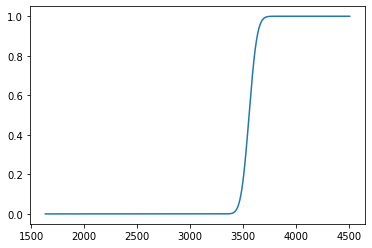

In [54]:
from matplotlib import pyplot as plt
%matplotlib inline

xx = np.linspace(1634.23296, 4504.59997, 1000)
yy = np.array([sc.gammainc(3556.25, e) for e in xx])

plt.plot(xx, yy)

In [26]:
(valid_mask_ikj[i][:, 1:]
                  * 1e5
                  * (sc.gammainc(a + 1e-5, x) - sc.gammainc(a, x))
                  / sc.gammainc(a, x))

/Users/trouleau/miniconda3/envs/var-wold/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [-0.08439,  0.     ,  0.     ],
       ...,
       [ 0.     ,      nan,  0.     ],
       [-0.37047,  0.     , -0.04624],
       [     nan,  0.     ,  0.     ]])

---

# Test variational inference algorithm *with fixed $\beta$*

Define the model object.

In [11]:
model_fixed_beta = WoldModelVariationalFixedBeta(verbose=True)
model_fixed_beta.observe(events)

Set the hyper-parameters and fit the model.

In [12]:
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

model_fixed_beta.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=100, tol=1e-5)

Explore the results.

In [13]:
alpha_hat_mean = np.round(model_fixed_beta._as_po / model_fixed_beta._ar_po, 2)
baseline_hat = alpha_hat_mean[0,:]
adjacency_hat = alpha_hat_mean[1:,:]

print('Baseline:')
print('---------')
print('Ground truth:')
print(baseline)
print('Estimated:')
print(baseline_hat)
print()

print('Adjacency:')
print('---------')
print('Ground truth:')
print(adjacency)
print('Estimated:')
print(adjacency_hat)
print()

Baseline:
---------
Ground truth:
[0.1 0.1 0.2]
Estimated:
[0.1  0.11 0.19]

Adjacency:
---------
Ground truth:
[[0.3 0.8 0.1]
 [0.2 0.3 0.1]
 [0.2 0.1 0. ]]
Estimated:
[[0.31 0.79 0.1 ]
 [0.2  0.28 0.11]
 [0.21 0.11 0.02]]

